In [ ]:
import geopandas as gpd
import pandas as pd
import fiona
import ujson as json
import csv
#import json
# Import the Dask libraries we need
import dask.dataframe as dd
import dask_geopandas as dgpd
import dask.bag as db
import numpy as np
import osmnx as ox
from algorithms import mm_utils
from shapely.geometry import Point

In [ ]:

tripdata_nodes = gpd.read_file('7-15-2022.gpx', layer = 'track_points')
    
with open('imu7-15-22 2_16_02.csv', mode = 'r') as f:
    tripdata_imu = csv.reader(f)
    tripdata_imu = pd.DataFrame(tripdata_imu)

# First we clean up the tripdata
tripdata_nodes = tripdata_nodes.dropna(axis=1, how = 'all')

# Let's convert the time into UNIX timestamps

from datetime import datetime as dt
import time

tripdata_nodes['time'] = (pd.to_datetime(tripdata_nodes['time']) - pd.Timestamp("1970-01-01").tz_localize("UTC")) // pd.Timedelta("1s")
tripdata_nodes = tripdata.rename(columns = {'time':'timestamp'})
tripdata_nodes = tripdata_nodes[['ele', 'timestamp', 'sat', 'geometry']]

tripdata_edges = mm_utils.point_to_traj(tripdata_nodes, columns = {'ele': 'average',
                                                                  'timestamp':'first',
                                                                  'sat':'first'})

# Now lets work on the IMU data.

tripdata_imu[0] = tripdata_imu[0].astype(float)

accel = []
for i in range(len(tripdata_imu)):
    row = tripdata_imu[[2,3,4]].loc[0]
    accel.append((float(tripdata_imu[[2,3,4]].loc[i].iloc[0]),
                  float(tripdata_imu[[2,3,4]].loc[i].iloc[1]),
                  float(tripdata_imu[[2,3,4]].loc[i].iloc[2])))

    
#tripdata_imu = tripdata_imu.rename(columns = {'0':'timestamp', '})

# We need to convert the times to UNIX timestamps.
    
timediff = dt.strptime('2022-07-15T02:16:02', '%Y-%m-%dT%H:%M:%S').timestamp() - float(tripdata_imu[0][0])

# Not going to overwrite tripdata_imu yet because we haven't done gyro yet
newdf = pd.DataFrame({'timestamp': tripdata_imu[0] + timediff, 'accelerometer' : accel,})

# We will separate the gyroscope data for later because it isn't synchronous with the rest of the data
# We will simply fuse this at the end

gyro = []
gyrotime = []

for i in range(len(tripdata_imu)):
    if tripdata_imu[5].loc[i] is not None:
        if float(tripdata_imu[5].loc[i]) == 4:
            gyrotime.append(float(newdf['timestamp'].loc[i]))
            gyro.append((float(tripdata_imu[[6,7,8]].loc[i].iloc[0]),
                      float(tripdata_imu[[6,7,8]].loc[i].iloc[1]),
                      float(tripdata_imu[[6,7,8]].loc[i].iloc[2])))

tripdata_gyro = pd.DataFrame({'timestamp':gyrotime, 'gyroscope':gyro})

tripdata_imu = newdf


NameError: name 'tripdata' is not defined

Now let's fuse!

In [ ]:
tripdata_nodes = mm_utils.fuse(mm_utils.fuse(tripdata_nodes, tripdata_imu, 'timestamp', 'nearest neighbor'), tripdata_gyro, 'timestamp', 'nearest neighbor')

<AxesSubplot:>

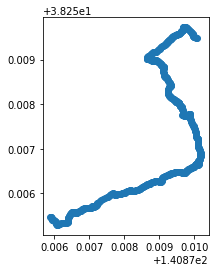

In [ ]:
tripdata_nodes.plot()

In [ ]:
from datetime import datetime as dt
import time

df = []
for item in data:
    date_str=item['timestamp']
    if date_str.find('.') != -1:
        date_str = date_str[:date_str.find('.')-1]
    elif date_str.find('Z') != -1:
        date_str = date_str[:date_str.find('Z')]
    
    date_obj = dt.strptime(date_str, '%Y-%m-%dT%H:%M:%S')
    tm = time.mktime(date_obj.timetuple())
    df.append({'type': 'Feature',
                 'geometry': {
                 'type': 'Point',
                 'coordinates': [item['longitudeE7']/10000000, item['latitudeE7']/10000000]
                 },
                'properties': {
                'timestamp': tm,
                'altitude': item['altitude'],
                'velocity': item['velocity'],
                'heading': item['heading'],
                'accuracy': item['accuracy']
                }}
                )

In [ ]:
geojsonf = {"type": "FeatureCollection", "features": df}

In [ ]:
json.dumps(geojsonf)

'{"type":"FeatureCollection","features":[{"type":"Feature","geometry":{"type":"Point","coordinates":[140.8726359,38.259086]},"properties":{"timestamp":1657675860.0,"altitude":81,"velocity":0,"heading":121,"accuracy":6}},{"type":"Feature","geometry":{"type":"Point","coordinates":[140.872531,38.2590354]},"properties":{"timestamp":1657675804.0,"altitude":81,"velocity":0,"heading":180,"accuracy":11}},{"type":"Feature","geometry":{"type":"Point","coordinates":[140.8803704,38.2568974]},"properties":{"timestamp":1657684680.0,"altitude":96,"velocity":2,"heading":39,"accuracy":46}},{"type":"Feature","geometry":{"type":"Point","coordinates":[140.8724334,38.2604857]},"properties":{"timestamp":1657675803.0,"altitude":81,"velocity":0,"heading":169,"accuracy":13}},{"type":"Feature","geometry":{"type":"Point","coordinates":[140.8723997,38.2596131]},"properties":{"timestamp":1657675715.0,"altitude":84,"velocity":3,"heading":2,"accuracy":18}},{"type":"Feature","geometry":{"type":"Point","coordinates":[

In [ ]:
ubodt_gen = UBODTGenAlgorithm

In [ ]:
# Data Input

df_track = db.read_text('map-matching-dataset/*track.geojson').map(json.loads).map(gpd.GeoDataFrame.from_features)
df_network_edges = db.read_text('map-matching-dataset/*arcs.geojson').map(json.loads).map(gpd.GeoDataFrame.from_features)
df_network_nodes = db.read_text('map-matching-dataset/*nodes.geojson').map(json.loads).map(gpd.GeoDataFrame.from_features)
df_gt = db.read_text('map-matching-dataset/*route.geojson').map(json.loads).map(gpd.GeoDataFrame.from_features)

In [ ]:
# I wrote a utility function to do that, provided in mm_utils.

df_track_edges = df_track.map(mm_utils.point_to_traj, columns = {'timestamp':'first',
                                                       'altitude':'average',
                                                       'speed':'average',
                                                       'vertical accuracy':'last',
                                                       'horizontal accuracy':'last',
                                                       'oops':'notavalidmethod'})

In [ ]:


test1 = bdd_to_network(df_network_nodes.take(1)[0])
test1[1]
df_network_edges.take(1)[0]

/home/gjgress/.local/lib/python3.10/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


osmid  oneway lanes  \
u          v          key                                         
251071412  251071413  0                  23211165    True     2   
           1334394278 0                  98717177   False   NaN   
251071413  251071449  0                 551008309    True     2   
           251071451  0                 613962031    True     2   
251071449  1142048623 0                  98696749    True     2   
...                                           ...     ...   ...   
9256176170 2202918588 0                 210180076   False   NaN   
           2205393003 0    [210456978, 795883044]   False   NaN   
9259596899 3171938934 0                 113493078   False   NaN   
           5634274214 0                 113493078   False   NaN   
           1369859283 0                 122645445   False   NaN   

                                       name       highway  maxspeed reversed  \
u          v          key                                                      
251071412  251071413  0      Дорожная улица     secondary  RU:urban    False   
           1334394278 0      Дорожная улица     secondary        40    False   
251071413  251071449  0                 NaN       primary  RU:urban    False   
           251071451  0      Дорожная улица       primary  RU:urban    False   
251071449  1142048623 0                 NaN       primary  RU:urban    False   
...                                     ...           ...       ...      ...   
9256176170 2202918588 0                 NaN      tertiary       NaN     True   
           2205393003 0    Молодёжная улица   residential       NaN    False   
9259596899 3171938934 0                 NaN  unclassified       NaN     True   
           5634274214 0                 NaN  unclassified       NaN    False   
           1369859283 0                 NaN   residential       NaN     True   

                             length  \
u          v          key             
251071412  251071413  0      67.331   
           1334394278 0     172.199   
251071413  251071449  0     101.261   
           251071451  0     113.457   
251071449  1142048623 0     125.390   
...                             ...   
9256176170 2202918588 0     172.646   
           2205393003 0     954.445   
9259596899 3171938934 0      29.798   
           5634274214 0    2157.653   
           1369859283 0    1601.150   

                                                                    geometry  \
u          v          key                                                      
251071412  251071413  0    LINESTRING (54.25636 56.08177, 54.25649 56.081...   
           1334394278 0    LINESTRING (54.25636 56.08177, 54.25619 56.081...   
251071413  251071449  0    LINESTRING (54.25736 56.08162, 54.25771 56.081...   
           251071451  0    LINESTRING (54.25736 56.08162, 54.25784 56.081...   
251071449  1142048623 0    LINESTRING (54.25831 56.08198, 54.25825 56.082...   
...                                                                      ...   
9256176170 2202918588 0    LINESTRING (54.91693 56.18193, 54.91723 56.182...   
           2205393003 0    LINESTRING (54.91693 56.18193, 54.91679 56.181...   
9259596899 3171938934 0    LINESTRING (54.54212 56.24403, 54.54241 56.24382)   
           5634274214 0    LINESTRING (54.54212 56.24403, 54.54175 56.244...   
           1369859283 0    LINESTRING (54.54212 56.24403, 54.54221 56.244...   

                             junction  ref bridge access  
u          v          key                                 
251071412  251071413  0           NaN  NaN    NaN    NaN  
           1334394278 0           NaN  NaN    NaN    NaN  
251071413  251071449  0    roundabout  NaN    NaN    NaN  
           251071451  0           NaN  NaN    NaN    NaN  
251071449  1142048623 0    roundabout  NaN    NaN    NaN  
...                               ...  ...    ...    ...  
9256176170 2202918588 0           NaN  NaN    NaN    NaN  
           2205393003 0           NaN  NaN    NaN  

/home/gjgress/.local/lib/python3.10/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


,geometry
0,"LINESTRING (54.33588 56.11728, 54.33778 56.11567)"
1,"LINESTRING (54.33588 56.11728, 54.33451 56.11675)"
2,"LINESTRING (54.33588 56.11728, 54.33636 56.11747)"
3,"LINESTRING (54.25644 56.08185, 54.25735 56.08163)"
4,"LINESTRING (54.25644 56.08185, 54.25619 56.08163)"
...,...
18191,"LINESTRING (54.25050 56.09329, 54.25106 56.09310)"
18192,"LINESTRING (54.25050 56.09329, 54.24860 56.09393)"
18193,"LINESTRING (54.25050 56.09329, 54.25055 56.09333)"
18194,"LINESTRING (54.27674 56.09882, 54.27721 56.09894)"


In [ ]:
test2 = test1[1].sjoin_nearest(df_network_edges.take(1)[0].set_crs(4326), how = 'inner')

/home/gjgress/.local/lib/python3.10/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
/home/gjgress/.local/lib/python3.10/site-packages/geopandas/array.py:340: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


<AxesSubplot:>

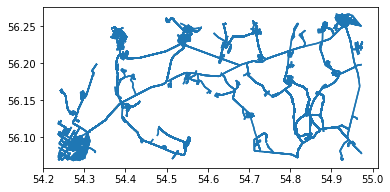

In [ ]:
test2.plot()

/home/gjgress/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:2334: UserWarning: `keep_geom_type=True` in overlay resulted in 122377 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  return geopandas.overlay(


<AxesSubplot:>

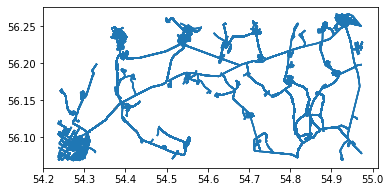

In [ ]:
test2.overlay(test1[1], how='intersection').plot()

/home/gjgress/.local/lib/python3.10/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


<AxesSubplot:>

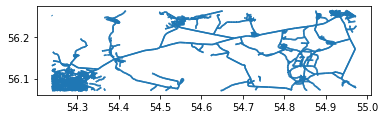

In [ ]:
df_network_edges.take(1)[0].plot()

In [ ]:
shortdf = dfbag.take(1)[0][['timestamp', 'altitude', 'vertical accuracy', 'horizontal accuracy','geometry']]
speed = dfbag.take(1)[0][['timestamp','speed']]

/home/gjgress/.local/lib/python3.10/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
/home/gjgress/.local/lib/python3.10/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [ ]:
rng = np.random.default_rng()
fakespeed1 = pd.DataFrame([])
for i in speed.index[:-1]:
    fakerow = pd.DataFrame([[speed.iloc[i][0] + rng.random()*1000,(speed.iloc[i][1] + speed.iloc[i+1][1])/2 + np.random.normal(0, (np.abs(speed.iloc[i][1] - speed.iloc[i+1][1]))/4)]], columns = ['timestamp','speed'], index = [i])
    fakespeed1 = pd.concat([fakespeed1, fakerow])
#fakespeed1 = fakespeed.sort_index().reset_index(drop=True)

fakespeed2 = speed
for i in speed.index[:-1]:
    fakerow = pd.DataFrame([[speed.iloc[i][0] + rng.random()*1000,(speed.iloc[i][1] + speed.iloc[i+1][1])/2 + np.random.normal(0, (np.abs(speed.iloc[i][1] - speed.iloc[i+1][1]))/4)]], columns = ['timestamp','speed'], index = [i+0.5])
    fakespeed2 = pd.concat([fakespeed2, fakerow])
fakespeed2 = fakespeed2.sort_index().reset_index(drop=True)

In [ ]:
fakespeed1.columns[1]

'speed'

In [ ]:
from algorithms import mm_utils
import importlib
importlib.reload(mm_utils)

print(mm_utils.fuse_simple(shortdf, fakespeed2,'average')['speed'])

0      5.670000
1      4.795244
2      4.432739
3      4.319257
4      4.100000
5      3.929557
6      3.860000
7      3.881983
8      4.530589
9      5.307742
10     5.870000
11     5.677451
12     6.585098
13     7.690000
14     8.888340
15     9.806581
16    12.395370
17    12.246513
18    12.260000
19    11.386794
20     8.910000
21     4.875845
22     2.490000
23     2.052125
24     1.292621
25     0.922850
26     0.890000
27     1.177310
28     1.387889
29     1.075231
30     0.840000
31     1.655779
32     2.650000
33     2.284484
34     2.171593
35     2.832277
36     3.400000
37     3.011903
38     3.449538
39     4.663751
40     5.370000
Name: speed, dtype: float64


In [ ]:
main_data = gpd.GeoDataFrame([])
print(type(main_data))
if (type(main_data) != list) and ((type(main_data) != pd.DataFrame) and (type(main_data) != gpd.GeoDataFrame)):
    print(1)
else:
    print(0)

<class 'geopandas.geodataframe.GeoDataFrame'>
0


In [ ]:
# We load all the JSON files

dfbag = db.read_text('BDD100K/train/*.json')

In [ ]:
df = dfbag.map_partitions(json.loads)

In [ ]:
db1.npartitions

70100

In [ ]:
%%time

from joblib import Parallel, delayed
import sys

def bdd_reformat(jsonf):        
    listf = []
    if jsonf.get('gps') != None:
        for item in jsonf['gps']:
            listf.append({"type": "Feature",
          "geometry": {
            "type": "Point",
            "coordinates": [item["longitude"], item["latitude"]]
          },
          "properties": {
            "timestamp": item["timestamp"],
            "altitude": item["altitude"],
            "speed": item["speed"],
            "vertical accuracy": item["vertical accuracy"],
            "horizontal accuracy": item["horizontal accuracy"]
          }})
        geojsonf = {"type": "FeatureCollection", "features": listf}
        dfjson = json.dumps(geojsonf)
        return dfjson
    elif jsonf.get('locations') != None:
        dfjson = json.dumps(jsonf)
        return dfjson


# If you try to parallelize with Dask here, you'll run into some issues
# Because there are thousands of partitions, Dask will attempt to schedule them all simultaneously
# But Dask isn't built to schedule thousands of partitions (I think), so it will crash your kernel
# Instead, we will use a more rudimentary parellelization process, and come back to Dask when the time is right


#Parallel(n_jobs=6,verbose=100)(delayed(bdd_reformat)(db1.partitions[i].compute()) for i in range(db1.npartitions))


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


AttributeError: 'Bag' object has no attribute 'partitions'

In [ ]:
%time

df_temp = df.map_partitions(bdd_reformat,meta = df)
df_temp.compute()

CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 µs
Wall time: 5.01 µs


In [ ]:
geofp = []

for row in fp["gps"]:
    temp = {"type": "Feature",
  "geometry": {
    "type": "Point",
    "coordinates": [row["longitude"], row["latitude"]]
  },
  "properties": {
    "timestamp": row["timestamp"],
    "altitude": row["altitude"],
    "speed": row["speed"],
    "vertical accuracy": row["vertical accuracy"],
    "horizontal accuracy": row["horizontal accuracy"]
  }}
    geofp.append(temp)

geofp = {"type": "FeatureCollection", "features": geofp}
        
geojsonfp = json.dumps(geofp)
with open('data.json', 'w') as f:
  f.write(geojsonfp)

# Enable GeoJSON driver
fiona.drvsupport.supported_drivers["GeoJSON"] = "r"

tripdata1 = gpd.read_file("data.json", enabled_drivers="GeoJSON")